In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from datetime import datetime

# import warnings
# warnings.filterwarnings("ignore")


In [15]:
data = pd.read_csv('./AAPL.csv')
print(data.shape)
print(data.sample(7))

data.info()
data['Date'] = pd.to_datetime(data['Date'])

(1258, 7)
            Date        Open        High         Low       Close   Adj Close  \
132   2018-10-03   57.512501   58.367500   57.445000   58.017502   55.717304   
350   2019-08-16   51.070000   51.790001   50.959999   51.625000   50.347588   
1148  2022-10-17  141.070007  142.899994  140.270004  142.410004  141.957413   
1084  2022-07-18  150.740005  151.570007  146.699997  147.070007  146.399246   
683   2020-12-10  120.500000  123.870003  120.150002  123.239998  121.592484   
649   2020-10-22  117.449997  118.040001  114.589996  115.750000  114.005920   
1161  2022-11-03  142.059998  142.800003  138.750000  138.880005  138.438629   

         Volume  
132   114619200  
350   110481600  
1148   85250900  
1084   81420900  
683    81312200  
649   101988000  
1161   97918500  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       125

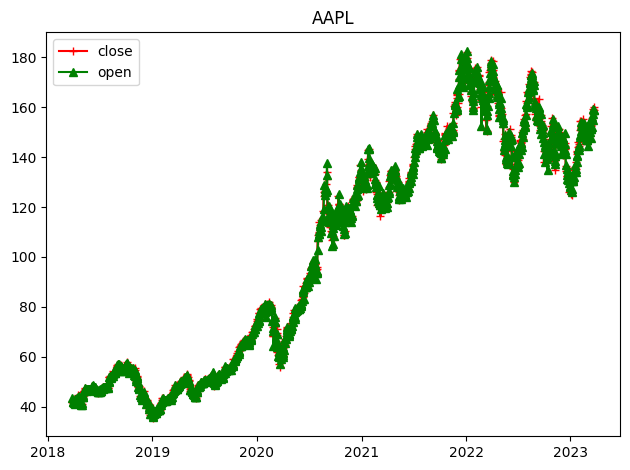

In [16]:
plt.figure()
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()


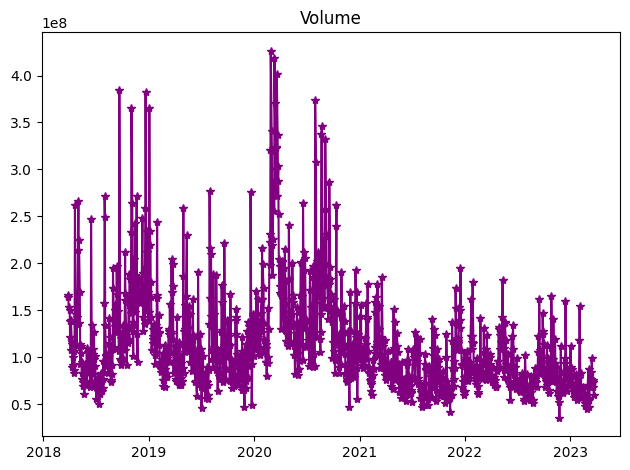

In [17]:

plt.figure()
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

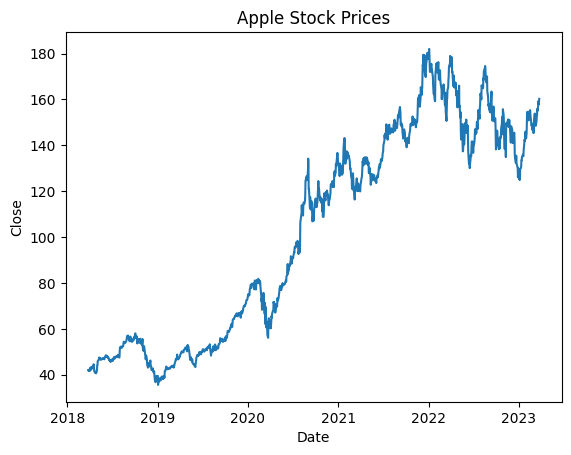

In [18]:
prediction_range = data.loc[(data['Date'] > datetime(2018,3,27)) & (data['Date'] < datetime(2023,3,27))]
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [19]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1196


In [20]:

from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []
  
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

2023-03-27 22:50:54.930767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:50:54.933341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:50:54.935393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fd740438310>>

In [22]:

model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10


2023-03-27 22:50:55.371134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:50:55.373142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:50:55.374238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 5s 67ms/step - loss: 0.0415
Epoch 2/10
36/36 [==============================] - 2s 63ms/step - loss: 0.0132
Epoch 3/10
36/36 [==============================] - 2s 64ms/step - loss: 0.0110
Epoch 4/10
36/36 [==============================] - 2s 65ms/step - loss: 0.0118
Epoch 5/10
36/36 [==============================] - 2s 64ms/step - loss: 0.0105
Epoch 6/10
36/36 [==============================] - 2s 61ms/step - loss: 0.0111
Epoch 7/10
36/36 [==============================] - 2s 61ms/step - loss: 0.0100
Epoch 8/10
36/36 [==============================] - 2s 61ms/step - loss: 0.0092
Epoch 9/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0114
Epoch 10/10
36/36 [==============================] - 2s 66ms/step - loss: 0.0083


In [23]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-03-27 22:51:21.591579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:51:21.593712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:51:21.594889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 24ms/step
MSE 27.17202211333314
RMSE 5.2126789766235495


/tmp/ipykernel_8757/700852542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


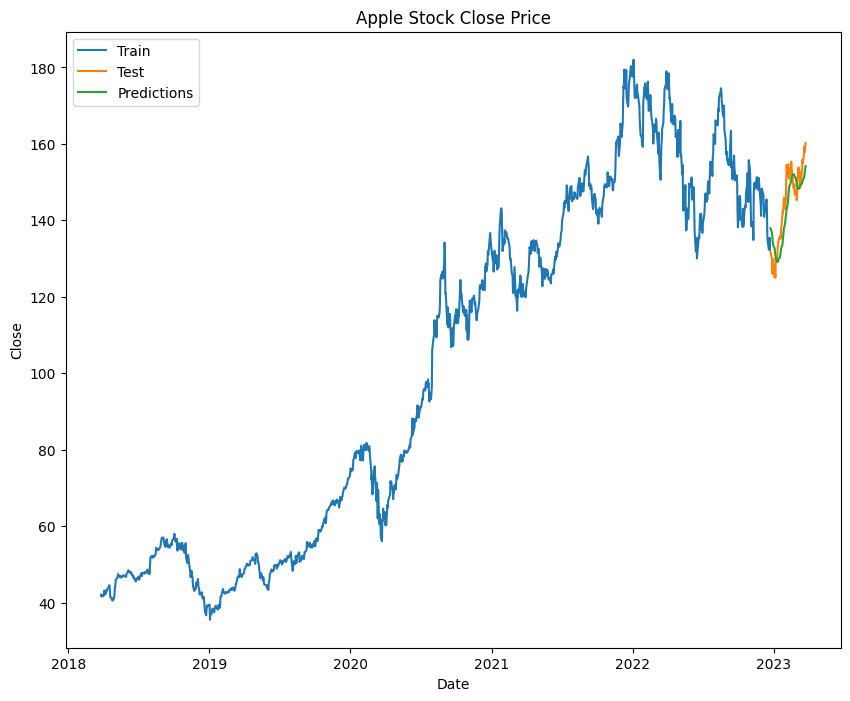

In [32]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([1000,1500,120,180])